##  Optimze and a Dense Neural Network for gap filling and feature identification

** With a few tweaks to RepRunner, an LSTM can be run instead

In [1]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from multiprocessing import Pool
from functools import partial
from sklearn import metrics

## Personal Modules
import ReadStandardTimeFill as RSTF
import importlib
import DenseNet as Dense
import MiscFuncs as MF
importlib.reload(Dense)
importlib.reload(RSTF)
importlib.reload(MF)

# %matplotlib inline

%matplotlib notebook
%config IPCompleter.greedy=True

from scipy.optimize import minimize, curve_fit
from scipy.stats import norm
from matplotlib import cm

from scipy import stats

from ipywidgets import FloatProgress, HTML
from IPython.display import display, clear_output
import os  
import shutil
from keras import backend as K
try:pool.close()
except:pass

import json
import os

def RecWrite(AllRes,Path):
    for f in AllRes.keys():
        try:
            os.mkdir(Path)
        except:
            pass
        for t in AllRes[f].keys():
            if t != 'Results' and t != 'Records' and t!= 'Removed':
                for p in AllRes[f][t].keys():
                    if t == 'X':
                        np.save(Path+f+'_'+t+'_'+str(p)+'.npy',AllRes[f][t][p][0])
                        
                    else:
                        for p2 in AllRes[f][t][p].keys():
                            print(f,t,p,p2)
                            np.save(Path+f+'_'+t+'_'+str(p)+'_'+str(p2)+'.npy',AllRes[f][t][p][p2])
        AllRes[f]['Records'].to_csv(Path+f+'_Runs.csv')
        AllRes[f]['Results'].to_csv(Path+f+'_Results.csv')
        
def RecRead(Path,Vars=['fco2','fch4','ER']):
    AllRes={}
    for f in Vars:
        try:
            AllRes[f]={}
            AllRes[f]['Records']=pd.read_csv(Path+f+'_Runs.csv',index_col=0)
            AllRes[f]['Results']=pd.read_csv(Path+f+'_Results.csv',index_col=0)
            AllRes[f]['Derivatives']={}
            AllRes[f]['SSQ'] ={}
            AllRes[f]['X'] = {}
            AllRes[f]['Yhat'] = {}
            AllRes[f]['Ytrue'] = {}
            AllRes[f]['Outputs'] = {}
        except:
            pass
    return(AllRes)
# print())


def Stats(mse,rmse,se,r2,j,params,i=0):
    df = pd.DataFrame(index = [str(j)+'_'+str(i)],#params['N'])],
          data={'Model':[params['Model']],'Size':j,'Nodes':params['N']
                ,'MSE':[mse],'RMSE':[rmse],'SE':[se],'r2':[r2],
                'Performance':0,'K':[params['K']]})
    return(df)

def t(p,n):
    alpha = 1-p
    df = n-1
    return(stats.t.ppf(alpha,df))

def Display (tar,prog1=None,prog2=None,MdLs=None,MdL=None):
    clear_output()
    display(tar)
    if prog1!=None:
        display(prog1)
    if prog2!=None:
        display(prog2)
    if MdLs!=None:
        display(MdLs)
    if MdL!=None:
        display(MdL)
tar = HTML(
            value=" ",
            placeholder='Target: ',
            description='Target: ',
        )
kwt = HTML(
        value=str(0),
        placeholder='Quit Score: ',
        description='Quit Score: ',
        )

cwd = os.getcwd()
alpha = .05
pd.set_option('max_colwidth',200)

Path = 'C:\\Users\\wesle\\NetworkAnalysis\\FishIsland/'  
Site='FishIsland'


File_Name = 'FI_Footprints_2022-02-23_2000mx2m.csv'
# File_Name = 'Data_Footprints_2021-09-17_2.csv'
# File_Name = 'Data_Footprints_2021-09-18_3.csv'
# File_Name = 'Data_Footprints_2021-09-14_4.csv'
# File_Name = 'Data_Footprints_2021-09-17_5.csv'
# File_Name = 'Resolution_Sensitivity.csv'
# File_Name = 'Data_Footprints_2021-09-21_2000mx2m.csv'
# File_Name = 'Data_Footprints_2022-02-16_2000mx2m.csv'
# File_Name = 'Data_Footprints_2021-09-26_2000mx2m.csv'
try:
    os.mkdir(Path+'/')
except:
    pass


Using TensorFlow backend.


# Check correlation between inputs

In [2]:
Full_Input  = {'AirTC_Avg':'Atmospheric','VPD':'Atmospheric',
            'u*':'Atmospheric','wind_speed':'Atmospheric','air_pressure':'Atmospheric',
            'NR_Wm2_Avg':'Radiation','PPFD_Avg':'Radiation',
            'Table_1':'Water','VWC_2':'Water','VWC_1':'Water',
            'Active_Layer_1':'SoilTemp',
            'Temp_2_5_1':'SoilTemp','Temp_5_1':'SoilTemp','Temp_15_1':'SoilTemp',
            'Temp_2_5_2':'SoilTemp','Temp_5_2':'SoilTemp','Temp_15_2':'SoilTemp',
            'Collapse':'LandCover',
            'Polygon':'LandCover','Rim':'LandCover',
            'Daytime':'Temporal',
#                'SoilMoist(4)':'VWC'#'DOY':'Temporal'
              }

# Full_Input  = {#'AirTC_Avg':'Atmospheric','VPD':'Atmospheric',
#             'u*':'Atmospheric','wind_speed':'Atmospheric',#'air_pressure':'Atmospheric',
#             'NR_Wm2_Avg':'Radiation',#'PPFD_Avg':'Radiation',
#             'Table_1':'Water',#'VWC_2':'Water','VWC_1':'Water',
#             'Active_Layer_1':'SoilTemp',
# #             'Temp_2_5_1':'SoilTemp','Temp_5_1':'SoilTemp',
#                'Temp_15_1':'SoilTemp',
# #             'Temp_2_5_2':'SoilTemp','Temp_5_2':'SoilTemp',
#                'Temp_15_2':'SoilTemp',
# #             'Collapse':'LandCover',
# #             'Polygon':'LandCover',
#                'Rim':'LandCover',
# #             'Daytime':'Temporal',#'DOY':'Temporal'
#               }

MP = True
# MP = False
if MP == True:
    processes = 2
else:
    processes = 1
Scope = 'Full'
# Scope = 'Smol'
Runs = 1
Threshold = 0.028#5
Threshold = 0.03
N_features = 8
    
params = Dense.Params(Path,Scope,None,MP=MP)

L = list(Full_Input.keys())
RST = RSTF.ReadStandardTimeFill(params,File_Name)
L.append('ch4_flux')
L.append('co2_flux')
Corr = RST.Master[L].corr()


print(Corr[['ch4_flux','co2_flux']].sort_values(by='co2_flux').round(3))

np.round((RST.Master[['fco2','fch4']].count())/30)
print(RST.Master[['ch4_flux','co2_flux']].count())

                ch4_flux  co2_flux
PPFD_Avg           0.681    -0.785
NR_Wm2_Avg         0.663    -0.770
ch4_flux           1.000    -0.630
VPD                0.392    -0.440
Daytime            0.327    -0.402
Temp_2_5_2         0.399    -0.390
AirTC_Avg          0.345    -0.384
Temp_5_2           0.307    -0.346
air_pressure       0.089    -0.225
u*                 0.334    -0.162
wind_speed         0.230    -0.091
Polygon            0.183    -0.090
VWC_1             -0.119    -0.023
Collapse           0.168     0.002
Rim               -0.178     0.019
VWC_2             -0.251     0.078
Temp_2_5_1        -0.050     0.095
Table_1           -0.448     0.100
Temp_5_1          -0.028     0.124
Active_Layer_1    -0.457     0.201
Temp_15_2         -0.531     0.494
Temp_15_1         -0.583     0.571
co2_flux          -0.630     1.000
ch4_flux    1441
co2_flux    2501
dtype: int64


In [3]:
Time = time.time()
AllRes={}
if __name__ == '__main__':
    for target in ['fco2','fch4']:#,
        params['target']=target
        Thresh = Threshold*1
        try:
            shutil.rmtree(params['Dpath']+'/'+target+'/')
        except: pass
        try: 
            os.mkdir(params['Dpath']+'/'+target+'/')
        except: pass
        AllRes[target]={}
        AllRes[target]['Derivatives'] = {}
        AllRes[target]['SSQ'] ={}
        AllRes[target]['X'] = {}
        AllRes[target]['Yhat'] = {}
        AllRes[target]['Ytrue'] = {}
        AllRes[target]['Outputs'] = {}
        Rm = []
        Input = list(Full_Input.keys())
        start = len(Input)
        IpKey=np.arange(0,start)
        IpDict={'Factors':Input.copy(),'Key':IpKey}
        tar.value=target
        prog2 = FloatProgress(min=0, max=100,description='Bootstrapping:')
        MdL = HTML(value=" ",placeholder='Testing: ',description='Testing: ')
        Continue = True
        run = 1
        Kill = Runs
        while len(Input)>0 and run == 1:
            params = Dense.Params(Path,Scope,target,MP=MP)
            j = len(Input)
            AllRes[target]['Derivatives'][j] = {}
            AllRes[target]['SSQ'][j] ={}
            AllRes[target]['Yhat'][j] = {}
            AllRes[target]['Ytrue'][j] = {}
            AllRes[target]['Outputs'][j] = {}
            Time2 = time.time()
            params['Inputs'] = Input
            MdL.value='N = '+str(j)+':  '+str(params['Inputs'])
            Display (tar,prog2=prog2,MdL=MdL)
            print(run,Kill)
            print('Inputs!: ', params['Inputs'])
            print('Total Runtime: ',time.time()-Time)
            print('Training Time: ', time.time()-Time2)
            params['Model'] = '+'.join(params['Inputs'])
            RST = RSTF.ReadStandardTimeFill(params, File_Name)#,resample='3H')
            if target == 'ER':
                RST.Master = RST.Master.loc[RST.Master['co2_flux']>0]
            params['N'] = int(np.round(RST.Master[target].count()*(1-params['validation_split'])/30))
            print('N: ',params['N'])
            params['Sname'] = 'Y_'
            params['Spath'] = params['Dpath']+'/'+target+'/'+str(j)+'_'+str(params['N'])+'/'
            print(params['Dpath'],params['Spath'])
            try:
                os.mkdir(params['Spath'])
            except:
                pass
            print(params['target'],params['Inputs'])
            RST.Scale(params['target'],params['Inputs']) 
            y = RST.y*1.0
            X = RST.X*1.0
            params['Memory'] = (math.floor(100/params['proc'])- 5/params['proc']) * .01
            Y_hat=[]
            y_true=[]
            X_true=[]
            index=[]
            ones=[]
            prog2.value=0
            Avs = []
            Derivatives = []
            Outputs=[]
            if MP == False:
                for k in range(params['K']):
                    results = Dense.Bootstrap(k,params=params,X=X,y=y,
                                             )
                    Y_hat.append(RST.YScaled.inverse_transform(results[0].reshape(-1,1)))
                    y_true.append(RST.YScaled.inverse_transform(results[1].reshape(-1,1)))
                    X_true.append(RST.XScaled.inverse_transform(results[2]))
                    ones.append(results[3])
                    prog2.value=(k+1)/params['K']*100
                    Avs.append(results[4])
                    Derivatives.append(results[5])
                    Outputs = results[6]
            else:
                pool = Pool(processes=processes,maxtasksperchild=75)
                for k,results in enumerate(pool.imap_unordered(partial(Dense.Bootstrap,params=params,X=X,y=y,
                                                                      ),range(params['K']))):
                    Y_hat.append(RST.YScaled.inverse_transform(results[0]))
                    y_true.append(RST.YScaled.inverse_transform(results[1]))
                    X_true.append(RST.XScaled.inverse_transform(results[2]))
                    ones.append(results[3])
                    prog2.value=(k+1)/params['K']*100
                    Avs.append(results[4])
                    Derivatives.append(results[5])
                    Outputs.append(results[6])
                pool.close()
            Y_hat = np.squeeze(np.asanyarray(Y_hat))
            y_true = np.squeeze(np.asanyarray(y_true))
            X_true = np.asanyarray(X_true)
            ones = np.asanyarray(ones)
            params['Memory'] = .95
            results = Dense.Sort_outputs(0,params=params,Y_hat=Y_hat,y_true=y_true,X_true=X_true,ones=ones)
            mse,rmse,se,r2,Y_Val,Y_hat_Val = results
            Level = Stats(mse,rmse,se,r2,j,params,i=params['N'])
            Level.to_csv('Temp.csv')
            Level['Thresh'] = Level['MSE']+Level['SE']
            Level['Remove'] = 'N/A'
            Min = Level.loc[Level['MSE']==Level['MSE'].min()]
            if Kill == Runs:
                Records = Level
            else:
                Records = Records.append(Level)
            Av = np.array(Avs).mean(axis=0)
#             Av = np.median(np.array(Avs),axis=0)#.mean(axis=0)
            Drv = np.array(Derivatives)
            Range = Drv.mean(axis=0).max(axis=1)-Drv.mean(axis=0).min(axis=1)
            SE = np.array(Avs).std(axis=0)**.5/(params['K']**.5)
            Key = str(j)+'_'+ str(params['N'])
            if Kill<Runs:
                IpDict['RC_Sum: '+Key]=np.zeros(Results.shape[0])
                IpDict['RC: '+Key]=np.zeros(Results.shape[0])
                IpDict['RG: '+Key]=np.zeros(Results.shape[0])
                IpDict['SE: '+Key]=np.zeros(Results.shape[0])
                IpDict['CS: '+Key]=np.zeros(Results.shape[0])
            Results = pd.DataFrame(data=IpDict)
            for I,A,S,R in zip(Input,Av,SE,Range):
                Results.loc[Results['Factors']==I,'RC: '+Key]=A
                Results.loc[Results['Factors']==I,'RG: '+Key]=R
                Results.loc[Results['Factors']==I,'SE: '+Key]=S
            Results['RC_Sum: '+Key]=Results['RC: '+Key]/Results['RC: '+Key].sum()
            IpDict['RC_Sum: '+Key]=Results['RC_Sum: '+Key].values
            IpDict['RC: '+Key]=Results['RC: '+Key].values
            IpDict['RG: '+Key]=Results['RG: '+Key].values
            IpDict['SE: '+Key]=Results['SE: '+Key].values
            Results = Results.sort_values('RC: '+Key)
            Resluts = Results.reset_index()
            Results['CS: '+Key]=Results['RC_Sum: '+Key].sort_values(ascending=False).cumsum().sort_values(ascending=False)
            Results = Results.sort_values('Key')
            IpDict['CS: '+Key]=Results['CS: '+Key].values
            Min = Records.loc[Records['MSE']==Records['MSE'].min()]

            ## Saving
            AllRes[target]['Records'] = Records
            AllRes[target]['Results'] = Results
            AllRes[target]['Derivatives'][j][params['N']] = Drv
            AllRes[target]['SSQ'][j][params['N']] = Avs
            AllRes[target]['X'][j] = X_true
            AllRes[target]['Outputs'][j][params['N']] = Outputs
            AllRes[target]['Yhat'][j][params['N']] = Y_hat_Val
            AllRes[target]['Ytrue'][j][params['N']] = Y_Val 

            Vee = 'RC_Sum: '+Key
            
#             NewInput = Results.loc[Results[Vee]>Thresh,'Factors'].values
#             NewInput = Results.loc[Results[Vee]>Thresh,'Factors'].values
            
            Thresh2 = Results[[Vee,'Factors']].sort_values(by=Vee)[-N_features:]#.values[0]
            NewInput = Results.loc[Results[Vee]>=Thresh2[Vee].min(),'Factors'].values

        
            if run <= 1 and Kill > 0:
                if len(NewInput) == len(Input):
                    run = 0
                elif len(NewInput)==0:
                    run = 0
                else:
                    Input = NewInput
                Kill -= 1
            else:
                run = 0

RecWrite(AllRes,Path)

print('Total Runtime: ',time.time()-Time)

HTML(value='fch4', description='Target: ', placeholder='Target: ')

FloatProgress(value=100.0, description='Bootstrapping:')

HTML(value="N = 8:  ['u*' 'wind_speed' 'NR_Wm2_Avg' 'Table_1' 'Active_Layer_1' 'Temp_15_1'\n 'Polygon' 'Rim']"…

1 0
Inputs!:  ['u*' 'wind_speed' 'NR_Wm2_Avg' 'Table_1' 'Active_Layer_1' 'Temp_15_1'
 'Polygon' 'Rim']
Total Runtime:  1233.8285512924194
Training Time:  0.005013704299926758
N:  43
C:\Users\wesle\NetworkAnalysis\FishIsland/ C:\Users\wesle\NetworkAnalysis\FishIsland//fch4/8_43/
fch4 ['u*' 'wind_speed' 'NR_Wm2_Avg' 'Table_1' 'Active_Layer_1' 'Temp_15_1'
 'Polygon' 'Rim']


C:\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:709: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current, self.best):


fco2 Derivatives 21 75
fco2 Derivatives 8 75
fco2 SSQ 21 75
fco2 SSQ 8 75
fco2 Yhat 21 75
fco2 Yhat 8 75
fco2 Ytrue 21 75
fco2 Ytrue 8 75
fco2 Outputs 21 75
fco2 Outputs 8 75
fch4 Derivatives 21 43
fch4 Derivatives 8 43
fch4 SSQ 21 43
fch4 SSQ 8 43
fch4 Yhat 21 43
fch4 Yhat 8 43
fch4 Ytrue 21 43
fch4 Ytrue 8 43
fch4 Outputs 21 43
fch4 Outputs 8 43
Total Runtime:  1438.0703213214874


Index(['21_75', '8_75'], dtype='object')
                                                                           Model  \
8_75  VPD+wind_speed+PPFD_Avg+Active_Layer_1+Temp_5_1+Temp_5_2+Temp_15_2+Daytime   

      Size  Nodes       MSE      RMSE        SE        r2  Performance   K  \
8_75     8     75  0.141006  0.375508  0.001697  0.936704            0  30   

        Thresh Remove  
8_75  0.142703    N/A  
Group
LandCover      0.000000
Water          0.000000
Temporal       0.056413
Atmospheric    0.089866
SoilTemp       0.217907
Radiation      0.635814
Name: RC_Sum: 8_75, dtype: float64


<IPython.core.display.Javascript object>


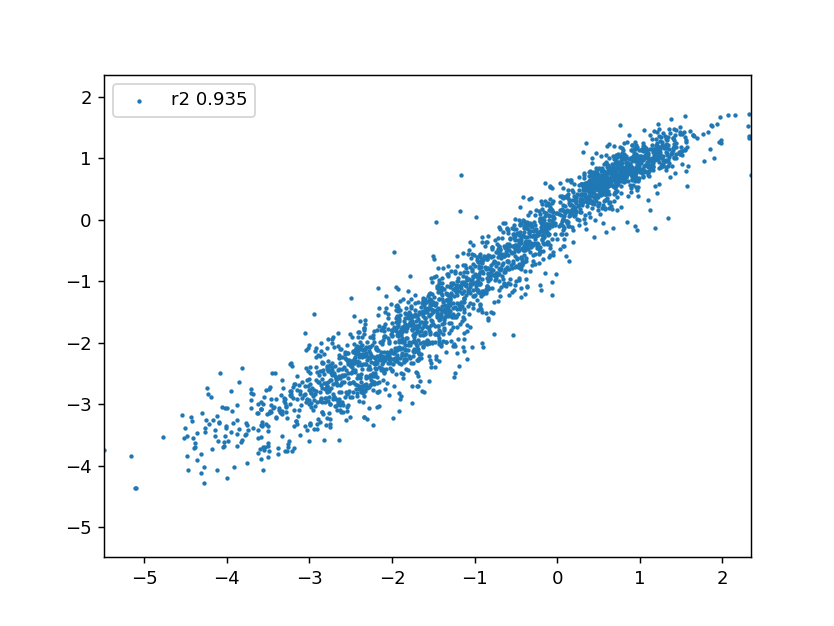

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


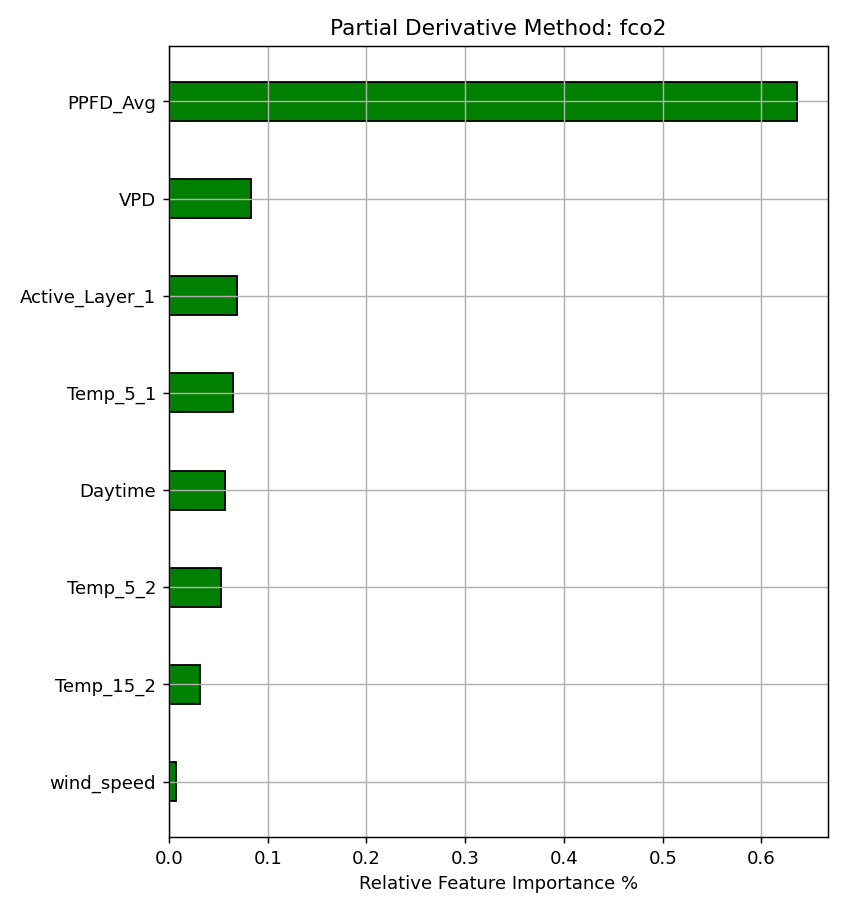

   index         Factors  Key  RC_Sum: 21_75    RC: 21_75  RG: 21_75  \
0      3      wind_speed    3       0.036002   300.972926   0.354016   
1     16       Temp_15_2   16       0.032733   273.642888   0.537504   
2     15        Temp_5_2   15       0.028306   236.635487   0.372795   
3     20         Daytime   20       0.057377   479.673343   0.086567   
4     12        Temp_5_1   12       0.044293   370.288246   0.487503   
5     10  Active_Layer_1   10       0.043345   362.364761   0.911746   
6      1             VPD    1       0.055536   464.280314   0.890494   
7      6        PPFD_Avg    6       0.489788  4094.615951   1.654282   

   SE: 21_75  CS: 21_75  RC_Sum: 8_75     RC: 8_75  RG: 8_75  SE: 8_75  \
0   2.012050   0.726342      0.006896    79.701075  0.346494  1.215675   
1   2.086787   0.759074      0.031153   360.029420  0.843526  2.685249   
2   2.674924   0.787380      0.052347   604.964126  0.686657  2.703717   
3   4.215110   0.547166      0.056413   651.961676  0.0

In [4]:
# Model_Index = None
F = 'fco2'
Model_Index = '21_75'
Model_Index = '8_75'

# F = 'fch4'
# Model_Index = '21_43'
# Model_Index = '8_43'

Results = AllRes[F]['Results'].copy()
Records = AllRes[F]['Records'].copy()
if Model_Index == None:
    Best = Records.loc[Records['Size']==Records['Size'].min()]
else:
    Best = Records.loc[Records.index==Model_Index]    
print(Records.index)
print(Best)
Size = Best.Size.values[0]
Nodes = Best.Nodes.values[0]
Derivatives = np.load(Path+F+'_Derivatives_'+Best.index.values[0]+'.npy')
Mean = Derivatives.mean(axis=0)
X = np.load(Path+F+'_X_'+str(Size)+'.npy')
                 
Results['Group']=''
A=[]
for val in Results.Factors.values:
    try:Resluts.loc[Results['Factors']==val,'Group']=Classes[val]
    except:pass
    A.append(Full_Input[val])
Results['Group']=A
print(Results.groupby('Group').sum()['RC_Sum: '+Best.index.values[0]].sort_values())

RMSE=[]
plt.figure()
y = np.load(Path+F+'_Yhat_'+Best.index.values[0]+'.npy')
x = np.load(Path+F+'_Ytrue_'+Best.index.values[0]+'.npy')
for i in range(y.shape[0]):
    df = pd.DataFrame(data={'target':y[i],'y':x[i]}).dropna()
    rmse = metrics.mean_squared_error(df['y'],df['target'])**.5
    RMSE.append(rmse)
plt.legend()
slope,intercept,r,p,SE = stats.linregress(df['y'],df['target'])
df = pd.DataFrame(data={'target':np.nanmean(y,axis=0),'y':np.nanmean(x,axis=0)}).dropna()
plt.scatter(df['y'],df['target'],s=2,label='r2 '+str(np.round(r**2,3)))
plt.xlim(df['y'].min(),df['y'].max())
plt.ylim(df['y'].min(),df['y'].max())
plt.legend()


a = 'RC: '+Best.index.values[0]
ase = 'SE: '+Best.index.values[0]
try:
    Results = Results.loc[Results[a]>0].sort_values(a,ascending=True).reset_index()
except:
    pass
fig,ax=plt.subplots(figsize=(6.5,7))
ax.barh(Results.index,Results['RC_Sum: '+Best.index.values[0]],
         height=.4,color='g',edgecolor='k')
# ax2=ax.twiny()
# ax2.plot(Results['CS: '+Best.index.values[0]],Results.index,color='k')
ax.set_yticks(Results.index)
ax.set_yticklabels(Results['Factors'].values)
ax.set_xlabel('Relative Feature Importance %')
ax.set_title('Partial Derivative Method: '+F)
ax.grid()
# ax.set_xlim(0,1)
# ax2.set_xlim(0,1)
plt.tight_layout()
plt.savefig('PAD_'+F+'_PrunedFactors.png')

print(Results)



In [ ]:
print(Results['RC: 21_75'])
print((Results['RC: 21_75']+Results['SE: 21_75']*1.96).sort_values())